In [3]:
%pylab inline
import numpy as np
import pickle as cp

Populating the interactive namespace from numpy and matplotlib


In [4]:
data = cp.load(open('G_data/gug.pkl','rb'))

In [5]:
data = data.transpose(2,1,0)

In [6]:
import pylab as plt

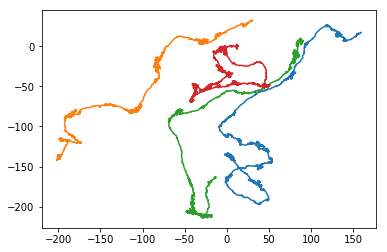

In [7]:
plt.plot(data[0][0],data[0][1])
plt.plot(data[1][0],data[1][1])
plt.plot(data[2][0],data[2][1])
plt.plot(data[4][0],data[4][1])

## Histograms of increments

In [8]:
increments = np.diff(data,axis=-1)

In [9]:
# increments lenght
dl = (increments**2).sum(axis=1)**.5

In [10]:
dl.shape

(50, 10000)

In [11]:
def gumbell(x,beta,mu):
    z = (x-mu)/beta
    g = 1./beta * exp(-(z+exp(-z)))
    return g

from scipy.optimize import curve_fit

--
mu 0.176877750687
beta 0.112132788805


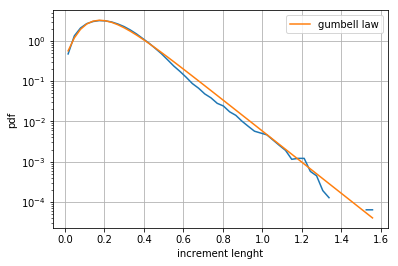

In [12]:
count,edges= np.histogram(dl.flatten(),bins=50,normed=1)
edges = (edges[:-1]+edges[1:])/2.
plt.semilogy(edges,count)
# plt.plot(edges,exp(-edges*8)*1e1)
(beta,mu),_ = curve_fit(gumbell,edges,count)
plt.plot(edges,gumbell(edges,beta,mu),label='gumbell law')

print("--")
print("mu",mu)
print("beta",beta)
plt.grid()
plt.xlabel('increment lenght')
plt.ylabel('pdf')
plt.legend()

I see a exponential decay above.. which is not good for a long tails 
as in LWs

In [13]:
increments.shape

(50, 2, 10000)

In [14]:
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

def meanstd_no_outliers(x,sigmas=3):
    mean = x.mean()
    std = x.std()
    idx = (x>(mean-sigmas*std) ) & (x<(mean+sigmas*std))

    mean = x[idx].mean()
    std = x[idx].std()
    return mean,std



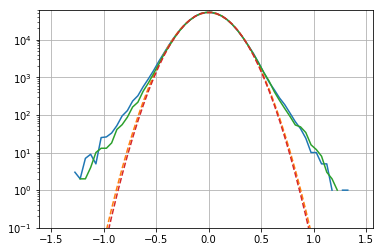

In [15]:
for j in [0,1]: # 0 stands for increments in x direction, 1 for y 
    X = increments[:,j,:].flatten() 
    count,edges= np.histogram(X,bins=np.arange(-1.5,1.5,.05))
    edges = (edges[:-1]+edges[1:])/2.
    plt.semilogy(edges,count)
    
#     mean = X.mean()
#     sigma = X.std()
    
    mean,sigma = meanstd_no_outliers(X)
    
    plt.plot(edges,gaus(edges,count.max(),mean,sigma),'--')
    
    plt.ylim(.1,6e4)
    plt.grid(1)

In [16]:
# area below the gaussian = sqrt(2)*sqrt(%pi)*a*sigma
gauss_area = (2*np.pi)**.5*count.max()*sigma
total_counts = sum(count)*.05
non_gauss = total_counts - gauss_area
print("gauss_area",gauss_area)
print("total_counts",total_counts)
print("non_gauss",non_gauss)

gauss_area 24835.2144058
total_counts 24999.95
non_gauss 164.735594241


Finally, heavy tails!
But the estimate needs some work bcs we have one hyper param

## brutal approach based on velocity

In [17]:
velocity = np.diff(data,axis=-1)
speed = (velocity**2).sum(axis=1)**.5
speed.shape

(50, 10000)

In [18]:
from scipy.ndimage.filters import gaussian_filter1d

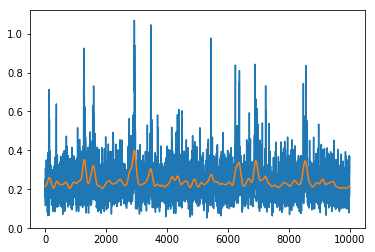

In [19]:
plt.plot(gaussian_filter1d(speed[0],sigma=1))
plt.plot(gaussian_filter1d(speed[0],sigma=50))

In [20]:
# direction vector
d = velocity/speed[:,np.newaxis,:]
p = (d[:,:,:-1]*d[:,:,1:]).sum(axis=1)

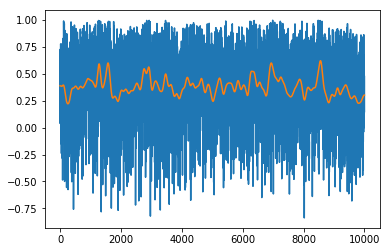

In [21]:
plt.plot(gaussian_filter1d(p[0],sigma=1))
plt.plot(gaussian_filter1d(p[0],sigma=50))

Text(0,0.5,'velocity')

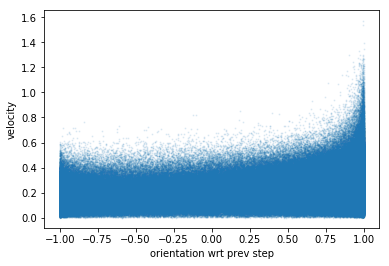

In [22]:
plt.scatter(p.flatten(),speed[:,1:].flatten(),s=1,alpha=.1);
plt.xlabel('orientation wrt prev step')
plt.ylabel('velocity')

Text(0,0.5,'velocity')

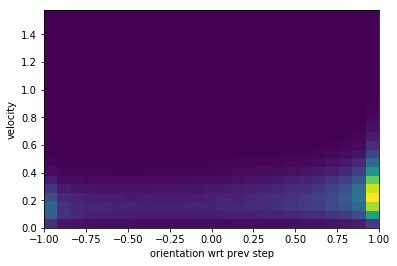

In [23]:
plt.hist2d(p.flatten(),speed[:,1:].flatten(),bins=25);
plt.xlabel('orientation wrt prev step')
plt.ylabel('velocity')

So, faster correlates to  more aligned consecutive steps, which makes sense.
And the visualization confirms

Text(0.5,1,'color coded by velocity')

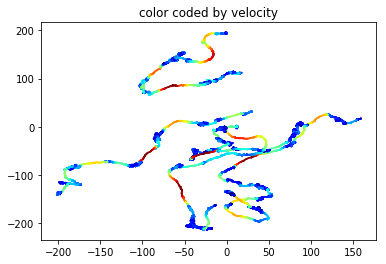

In [24]:
for j in range(5):
    plt.scatter(data[j][0],data[j][1],s=.5,c=plt.cm.jet(plt.Normalize()(gaussian_filter1d(speed[j],sigma=50))))
plt.title('color coded by velocity')

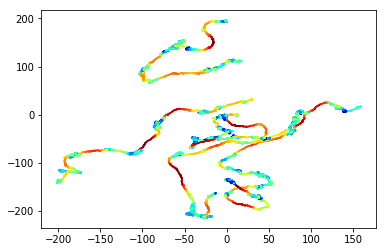

In [25]:
for j in range(5):
    plt.scatter(data[j][0],data[j][1],s=.5,c=plt.cm.jet(plt.Normalize()(gaussian_filter1d(p[j],sigma=50))))


One question is: what's the prob that two steps are aligned at given velocity $P(\theta|v)$, this can be computed from above, and used to split the trajectories

In [26]:
from scipy.ndimage.filters import median_filter

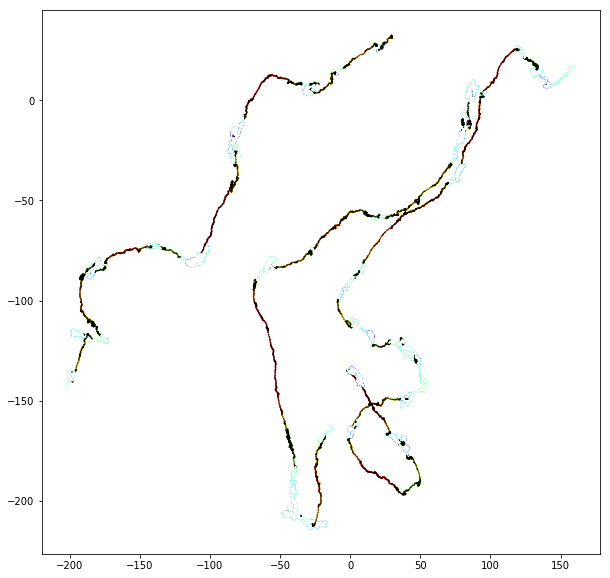

In [27]:
#hiperparameters
sigma = 50
threshold = .5 # or 50% of signal

plt.figure(figsize=(10,10))
for j in range(3):

    plt.scatter(data[j][0],data[j][1],s=.5,c=plt.cm.jet(plt.Normalize()(gaussian_filter1d(p[j],sigma=50))))
    
    mask = (plt.Normalize()(gaussian_filter1d(p[j],sigma=sigma))>threshold).astype(float)
    plt.scatter(data[j][0],data[j][1],s=.1,c=plt.cm.gray_r(mask))
    

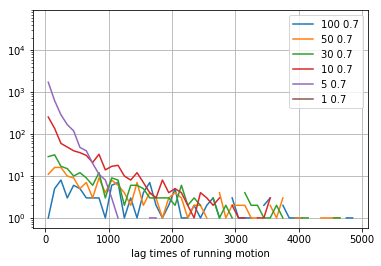

In [28]:
#hiperparameters
sigma = 50
threshold = .5 # or 50% of signal
def lag_times_hist(sigma,threshold):
    running = []
    diffusing = []
    for j in range(50):
        mask = (plt.Normalize()(gaussian_filter1d(p[j],sigma=sigma))>threshold).astype(float)
        # and now we compute the lag times .. guess how?!
        true_to_false = np.diff(mask)
        where_is_it = np.where(true_to_false)
        lags = np.diff(where_is_it)[0]
        other = lambda x: {1:0,0:1}[x]
        assigned_lags = {mask[0]:lags[::2],other(mask[0]):lags[1::2]}
        running.extend(assigned_lags[1])
        diffusing.extend(assigned_lags[0])
    count,edges = np.histogram(running,bins=np.arange(0,5000,100));
    edges = (edges[1:]+edges[:-1])/2
    plt.semilogy(edges,count,label=str(sigma)+' '+str(threshold))
    plt.xlabel('lag times of running motion')
    plt.legend(loc='best')
    plt.grid(1)

threshold = .7
    
lag_times_hist(100,threshold)
lag_times_hist(50,threshold)
lag_times_hist(30,threshold)
lag_times_hist(10,threshold)
lag_times_hist(5,threshold)
lag_times_hist(1,threshold)

Dunno if really feasible to split the path in diffusive and non diffusive in this way

## autocorrelation of speed

In [29]:
from scipy.signal import correlate

In [30]:
velocity.shape,speed.shape

((50, 2, 10000), (50, 10000))

In [31]:
speed_detrended = speed-speed.mean(axis=1)[:,np.newaxis]

In [32]:
def acorr(x):
    n = len(x)
    r = np.correlate(x,x,mode='full')[-n:]
    variance = x.var()
    return r/(variance*np.arange(n,0,-1))

speed_acorr = np.asarray([acorr(speed_detrended[j]) for j in range(speed.shape[0])])

In [33]:
mean_speed_acorr = speed_acorr.mean(axis=0)

/home/astyonax/.anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


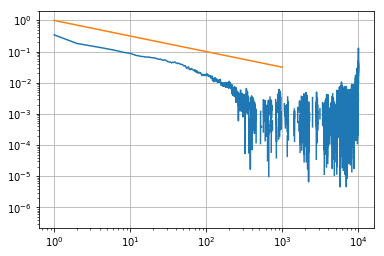

In [34]:
plt.loglog(mean_speed_acorr)
lags = np.arange(0,1000.)
plt.plot(lags,lags**-.5)
plt.grid()

Yeeee! autocorrelation as $1/\sqrt\tau$

## Acorr of velocity

In [64]:
def acfNd(v,n_lags=125):
    """
        inspired from vacf.py in this repo
        shape of v: [time,dimensions]
        does dot product in dimensions higher than 1
    """
    
    v = np.asarray(v,dtype=np.float) # make sure we have the right tipe
    lags_n = v.shape[0]
    lags_v = np.unique([int(l) for l in np.logspace(0,np.log10(lags_n),n_lags) if int(l) < lags_n])
    acf = np.zeros((len(lags_v),3))

    variance = np.sum(v*v,axis=1).mean()
    
    for i,lagv in enumerate(lags_v):
        tmp = np.sum(v[:-lagv]*v[lagv:],axis=1)
        
        v_corr = tmp.mean()
        v_corr_std = tmp.std(ddof=1)
        acf[i,0] = lagv
        acf[i,1] = v_corr
        acf[i,2] = v_corr_std
    acf[:,1:]/=variance
    return acf

In [67]:
print (velocity.shape)
velocity =velocity.transpose(0,2,1)
print (velocity.shape)

(50, 2, 10000)
(50, 10000, 2)


In [68]:
def vcorr_particles(velocity):
    try:
        # "async" as long as numpy releases GIL here and there or process pool is used
        from concurrent import futures
        with futures.ProcessPoolExecutor(max_workers=4) as executor:
            vcorr = executor.map(acfNd,velocity)
            vcorr = list(vcorr)
    except ImportError:
        print ("you don't have futures??? ")
        vcorr = [acfNd(j,n_lags=125) for j in velocity]
    return np.asarray(vcorr).mean(axis=0)

In [69]:
vcorr = vcorr_particles(velocity).T

In [70]:
vcorr.shape

(3, 101)

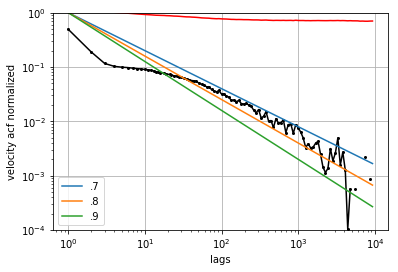

In [71]:
plt.grid(1)
# plt.errorbar(vcorr[0],vcorr[1],yerr=vcorr[2])#,'-o',ms=2) # does not work in loglog -_-

plt.loglog(vcorr[0],vcorr[1],'k-o',ms=2)
plt.loglog(vcorr[0],vcorr[1]+vcorr[2],'r-',ms=2)
plt.loglog(vcorr[0],vcorr[1]-vcorr[2],'r-',ms=2)

plt.ylim(1e-4,1)
plt.xlabel('lags')
plt.ylabel('velocity acf normalized')
plt.loglog(vcorr[0],vcorr[0]**-.7*1,label='.7')
plt.plot(vcorr[0],vcorr[0]**-.8*1,label='.8')
plt.plot(vcorr[0],vcorr[0]**-.9*1,label='.9')

plt.legend()

Would be nice to have the vcorr averaged on all particles

In [73]:
!mkdir -p G_data

In [72]:
np.save("G_data/vcor.npy",vcorr.T)